# Lung differentiation

The direct lung differentiation dataset from *Hurley, K. et al. 
Cell Stem Cell (2020) doi:10.1016/j.stem.2019.12.009*.

This dataset has multiple time points for the state manifold, but only one time point
for the clonal observation on day 27. 

In [1]:
import cospar as cs
import numpy as np

In [2]:
cs.logging.print_version()
cs.settings.verbosity=2
cs.settings.data_path='lung_data_paper' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='lung_figure_paper' # A relative path to save figures. If not existed before, create a new one.
cs.settings.set_figure_params(format='png',dpi=75,fontsize=14) # use png to reduce file size. 

Running cospar 0.0.11 (python 3.6.12) on 2021-04-14 14:46.


## Load data

In [3]:
adata_orig=cs.datasets.lung()

## Preprocessing (optional)

In [4]:
preprocessing=False
if preprocessing:
    cs.pp.get_highly_variable_genes(adata_orig,normalized_counts_per_cell=10000,min_counts=3, 
        min_cells=3, min_gene_vscore_pctl=80)

    cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.03,confirm_change=False) # optional step
    cs.pp.get_X_pca(adata_orig,n_pca_comp=40) 
    #cs.pp.get_X_umap(adata_orig,n_neighbors=20,umap_min_dist=0.3) # we want to keep the original embedding
    #cs.pp.get_state_info(adata_orig,leiden_resolution=0.5) # we want to keep the original state annotation

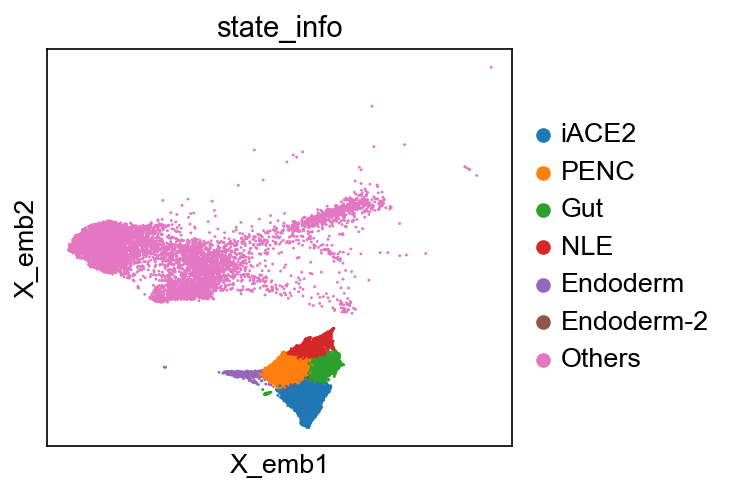

<Figure size 450x300 with 0 Axes>

In [5]:
cs.pl.embedding(adata_orig,color='state_info')

In [6]:
cs.hf.check_available_choices(adata_orig)

Current time ordering from simple sorting: ['D27' 'pos_17' 'pos_21']
Available transition maps: []
Available clusters: ['iACE2', 'Others', 'PENC', 'Endoderm', 'Gut', 'NLE']
Available time points: ['D27' 'pos_17' 'pos_21']
Clonal time points: ['D27']


### Basic clonal analysis

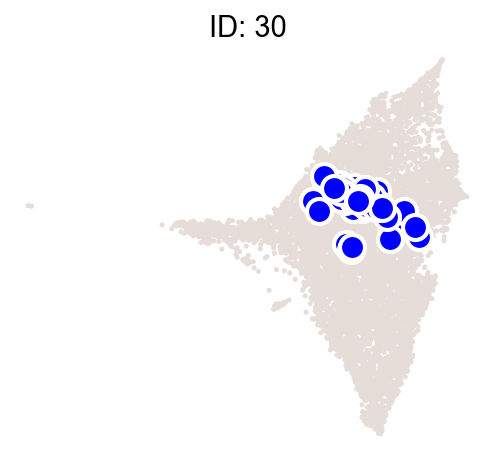

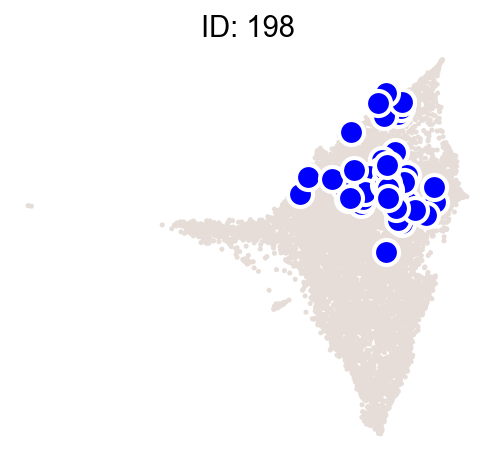

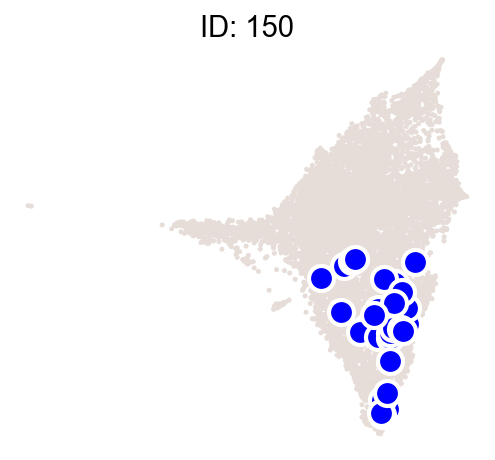

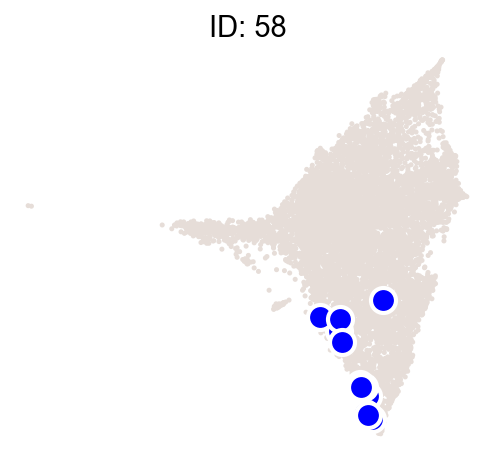

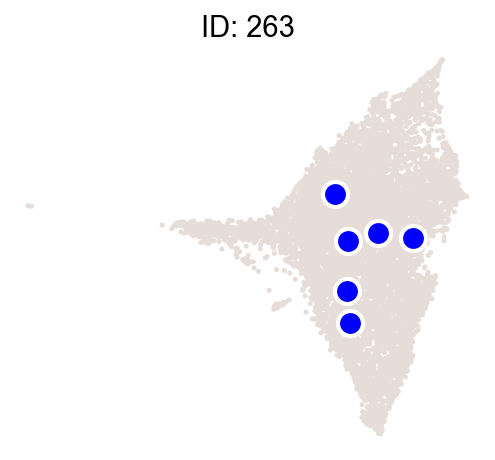

In [7]:
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[30,198,150,58,263],
            color_list=['blue','red'],selected_times=['D27'])

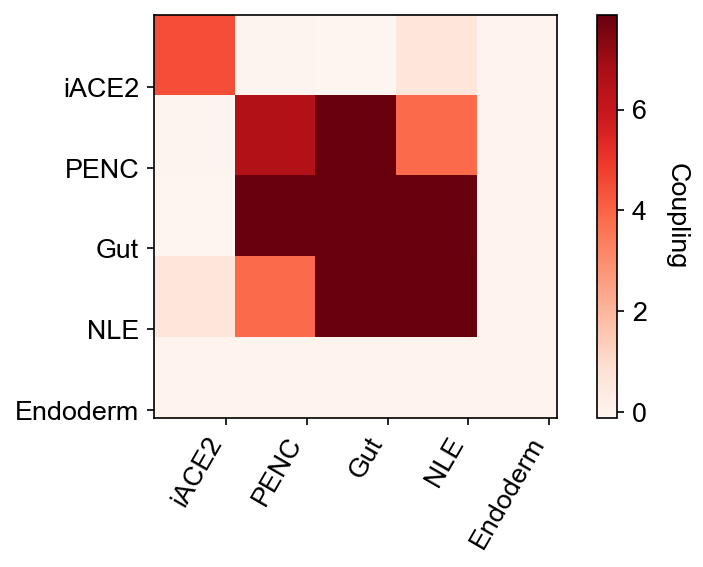

In [8]:
coupling=cs.pl.fate_coupling_from_clones(adata_orig,selected_times='D27',
            selected_fates=['iACE2', 'PENC', 'Gut', 'NLE', 'Endoderm'], color_bar=True,method='Weinreb')

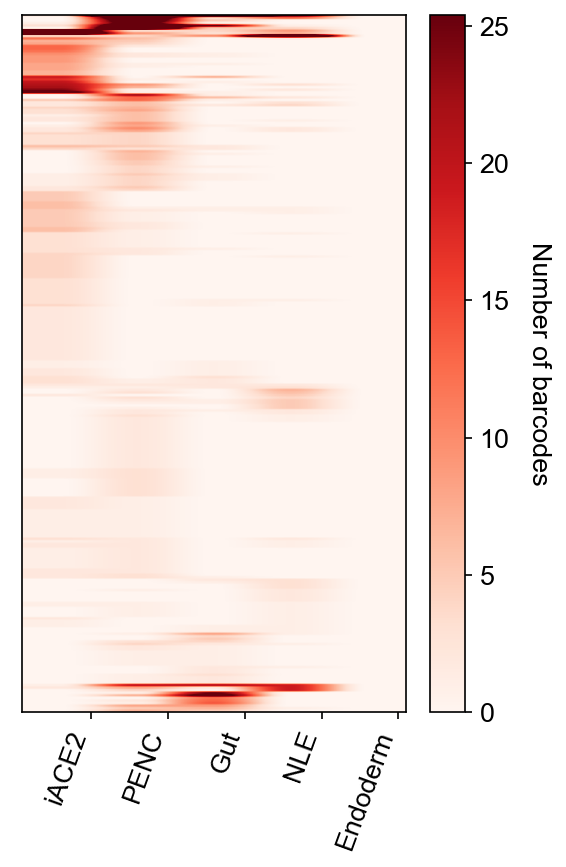

In [9]:
cs.pl.barcode_heatmap(adata_orig,selected_times='D27',
    selected_fates=['iACE2', 'PENC','Gut', 'NLE', 'Endoderm'], color_bar=True)

Current clone id: 0
Current clone id: 50
Current clone id: 100
Current clone id: 150
Current clone id: 200
Current clone id: 250


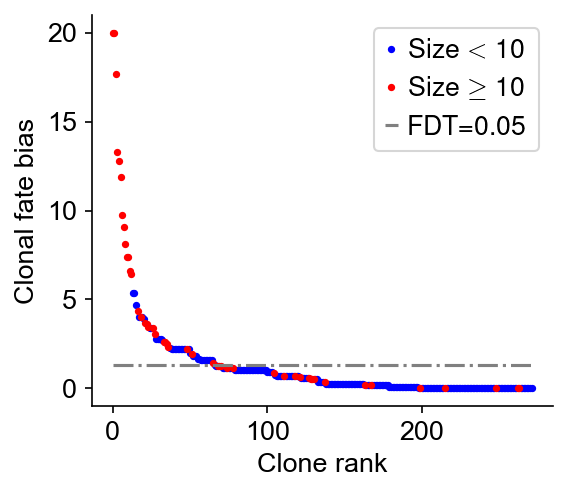

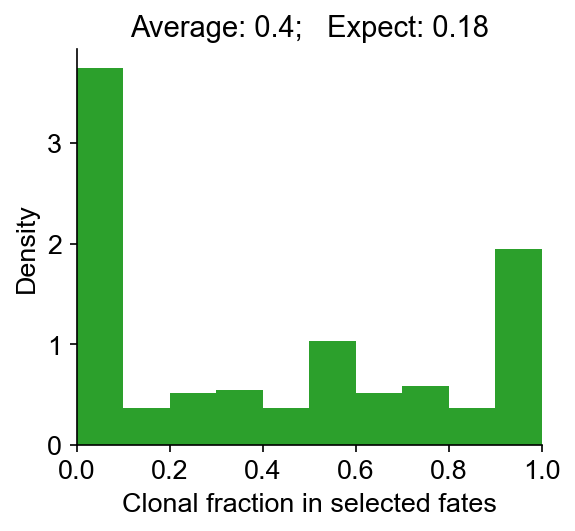

In [10]:
result=cs.pl.clonal_fate_bias(adata_orig,selected_fate='iACE2',
            clone_size_thresh=10,compute_new=False,alternative='two-sided')

## Infer transition map from end-point clones

It takes around 9 minutes to run it for the first time (the data has ~15000 cells). Later runs take < 3 mins. 

In [11]:
initial_time_points=['pos_17','pos_21']
clonal_time_point='D27'
adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points=['pos_17','pos_21'],
     later_time_point='D27',initialize_method='HighVar',HighVar_gene_pctl=80,max_iter_N=[1,3],
                                smooth_array=[20,15,10],sparsity_threshold=0.2)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: pos_17--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use the HighVar method for initialization-------
Step a: find the commonly shared highly variable genes------
Highly varable gene number: 3689 (t1); 3729 (t2). Common set: 1075
Step b: convert the shared highly variable genes into clonal info------
Total used genes=863 (no cells left)
Step c: compute the transition map based on clonal info from highly variable genes------
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.931
Finishing initialization using HighVar, used time 87.36846995353699
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iter

Trying to set attribute `.uns` of view, copying.


--------Current initial time point: pos_21--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use the HighVar method for initialization-------
Step a: find the commonly shared highly variable genes------
Highly varable gene number: 3794 (t1); 3729 (t2). Common set: 1152
Step b: convert the shared highly variable genes into clonal info------
Total used genes=1101 (no cells left)
Step c: compute the transition map based on clonal info from highly variable genes------
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.944
Finishing initialization using HighVar, used time 85.25039505958557
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Itera

### Save pre-computed map

In [12]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
# load_data=False
# if load_data:
#     ## updated Jan 27, 2021
#     #data_des='paper_OneTimeClone_t*pos_17*pos_21*D27'
#     data_des='CoSpar_OneTimeClone_t*pos_17*pos_21*D27' # computed on Jan 30, 2021
#     #data_des='Lung_StateInfo_t*pos_17*pos_21*D27'
#     adata=cs.hf.load_saved_adata_with_key(data_des)


### Plotting

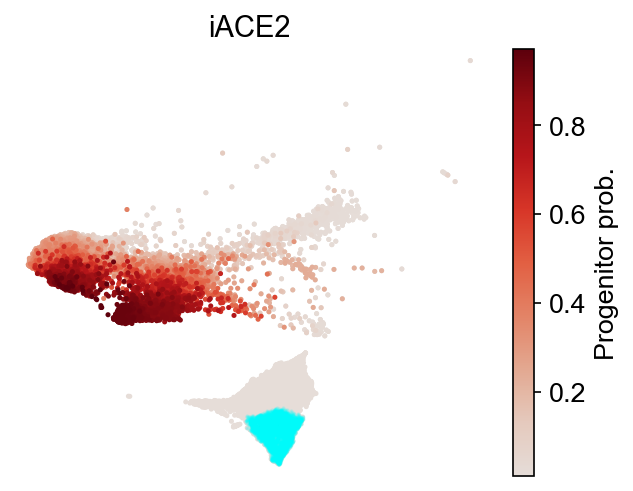

In [13]:
cs.pl.fate_map(adata,selected_fates=['iACE2'],selected_times=['pos_17','pos_21'],
               used_Tmap='transition_map',map_backward=True,plot_target_state=True)

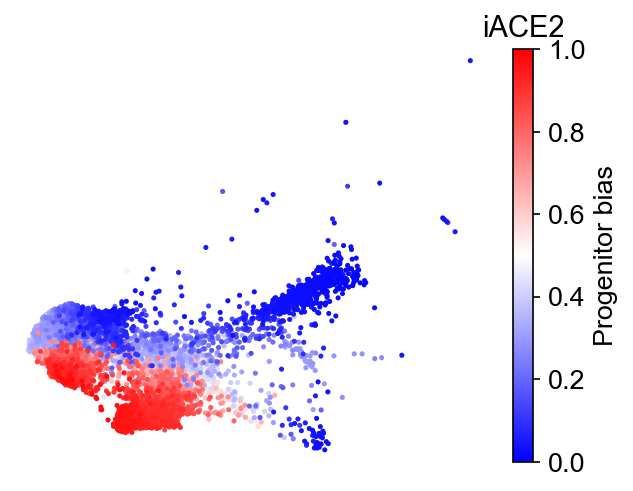

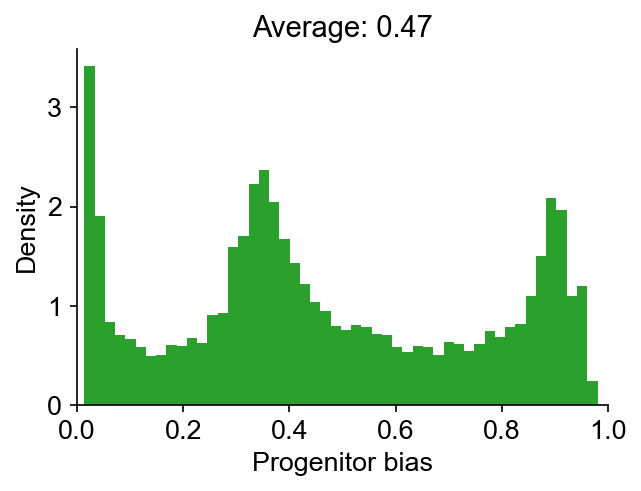

In [14]:
#cs.settings.set_figure_params(figsize=(4,3.5),format='png',fontsize=17)
selected_fates=['iACE2',['PENC', 'Gut', 'NLE', 'Endoderm']]
cs.pl.fate_bias(adata,selected_fates,used_Tmap='transition_map',
        plot_target_state=False,map_backward=True,method='norm-sum')

### DGE analysis

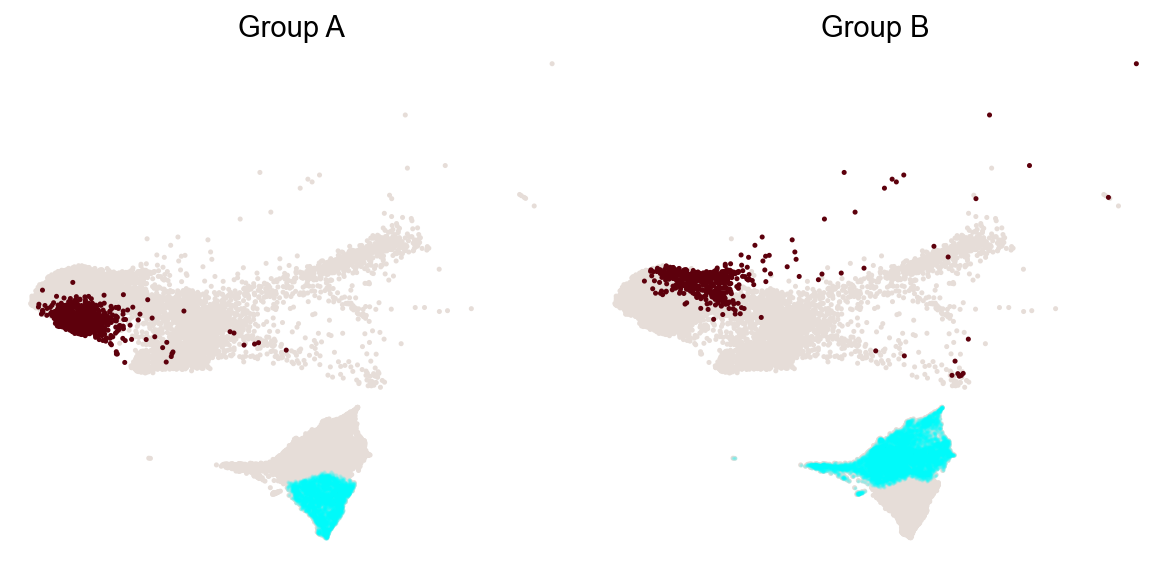

In [15]:
selected_fates=['iACE2',['PENC', 'Gut', 'NLE', 'Endoderm']]
cs.pl.dynamic_trajectory_from_fate_bias(adata,selected_fates,
            used_Tmap='transition_map',sum_fate_prob_thresh=0,bias_threshold_A=0.7,bias_threshold_B=0.2,
                            selected_times=['pos_17'])

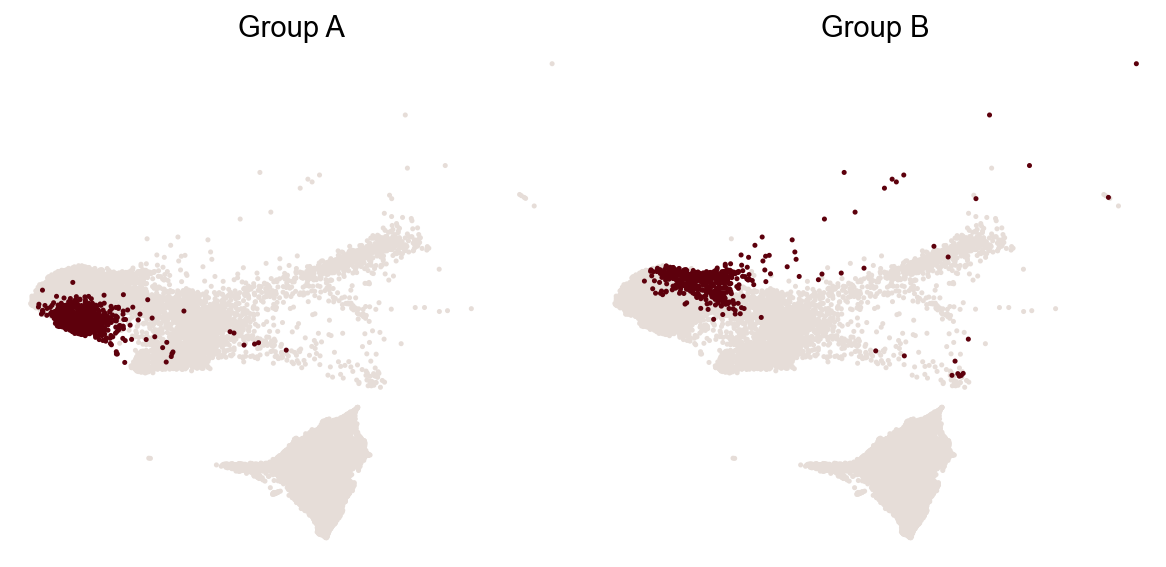

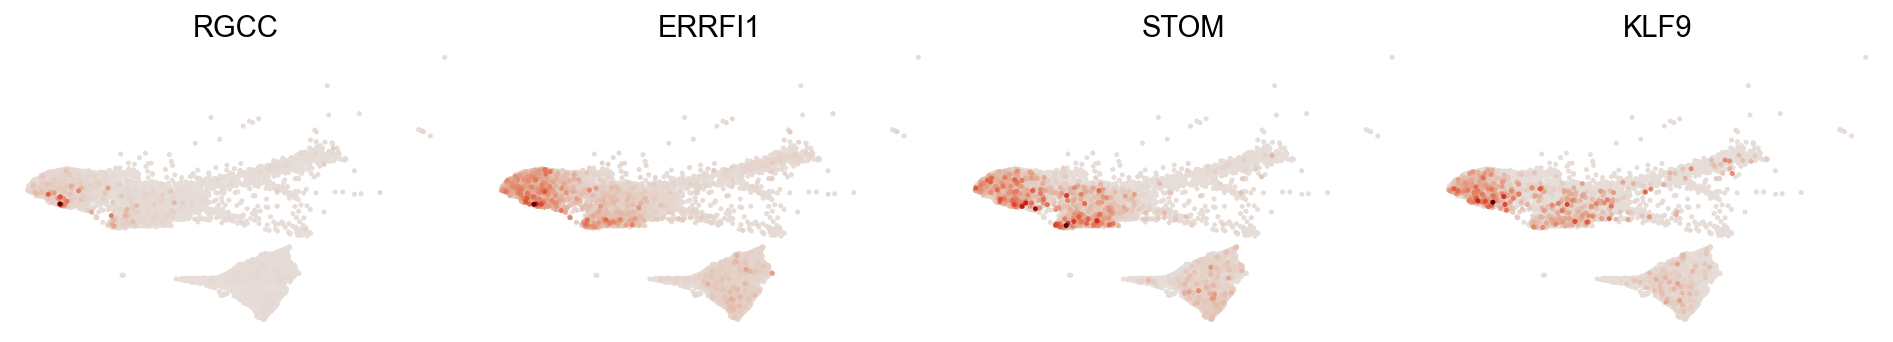

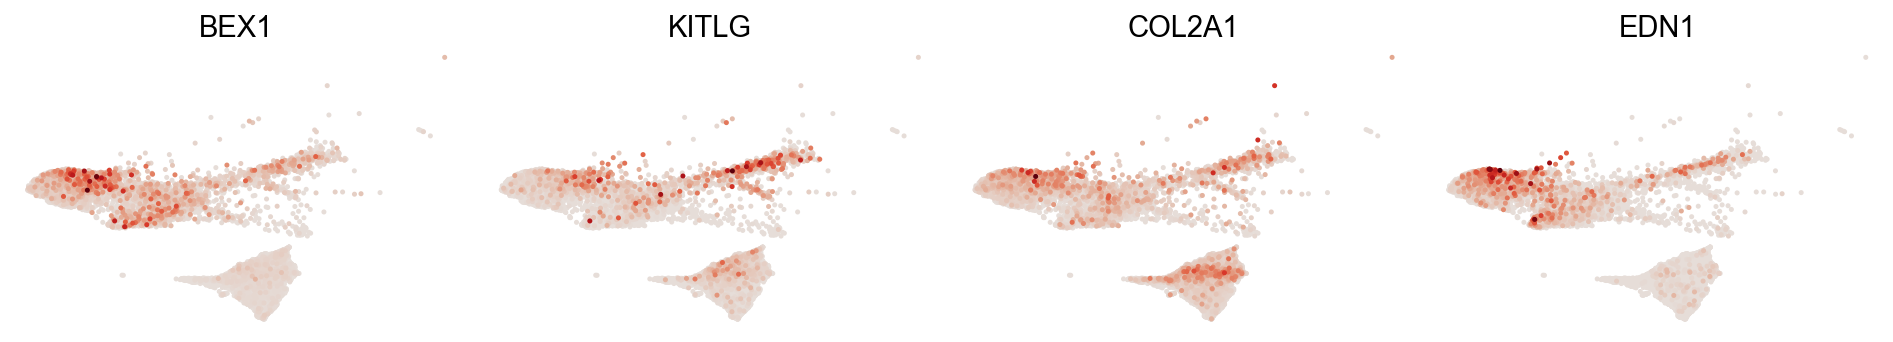

In [16]:
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=4)

In [17]:
dge_gene_A

,index,gene,Qvalue,mean_1,mean_2,ratio
0,169,RGCC,2.144346e-09,0.547450,4.596231,-1.854563
1,0,ERRFI1,3.870127e-93,5.101258,19.070242,-1.717879
2,21,STOM,3.486277e-32,0.579425,3.883361,-1.628475
3,114,KLF9,1.466090e-13,0.291544,2.570939,-1.467206
4,83,AQP3,1.737899e-17,0.039569,1.527965,-1.281992
...,...,...,...,...,...,...
370,194,MT-ND1,2.168010e-08,105.523079,116.645035,-0.143274
371,857,MT-ATP8,3.454531e-02,38.135532,41.240597,-0.110151
372,847,RPL5,3.229327e-02,6.439667,6.975648,-0.100364
373,632,MT-ATP6,6.538120e-03,267.924103,273.953888,-0.031991


In [18]:
# dge_gene_A.to_csv(f'{cs.settings.data_path}/lung_full_diff_Day17_biasd_towards_iACE2.csv')
# dge_gene_B.to_csv(f'{cs.settings.data_path}/lung_full_diff_Day17_biasd_towards_non_iACE2.csv')

In [19]:
group_idx_1=np.array(adata.obs['cell_group_A'])
group_idx_2=np.array(adata.obs['cell_group_B'])
sp_idx=((adata.obs_vector('MKI67')>0) | (adata.obs_vector('TOP2A')>0)) & (np.array(adata.obs['time_info'])=='pos_17')
group_idx_3=sp_idx & ~(group_idx_1 | group_idx_2) 

state_info=np.array(adata.obs['state_info']).astype('>U15')

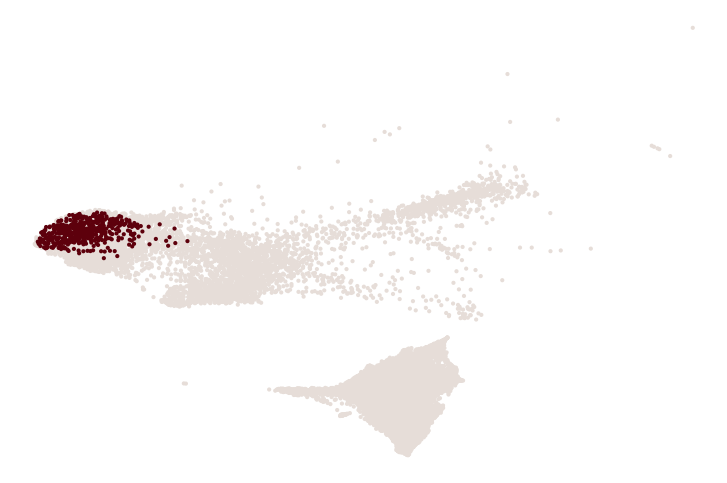

In [20]:
state_info[group_idx_1]='iACE2 prog.'
state_info[group_idx_2]='Non-iACE2 prog.'
state_info[group_idx_3]='Cycling prog.'
adata.obs['state_info']=state_info

x_emb=adata.obsm['X_emb'][:,0]
y_emb=adata.obsm['X_emb'][:,1]
cs.pl.customized_embedding(x_emb,y_emb,group_idx_3)

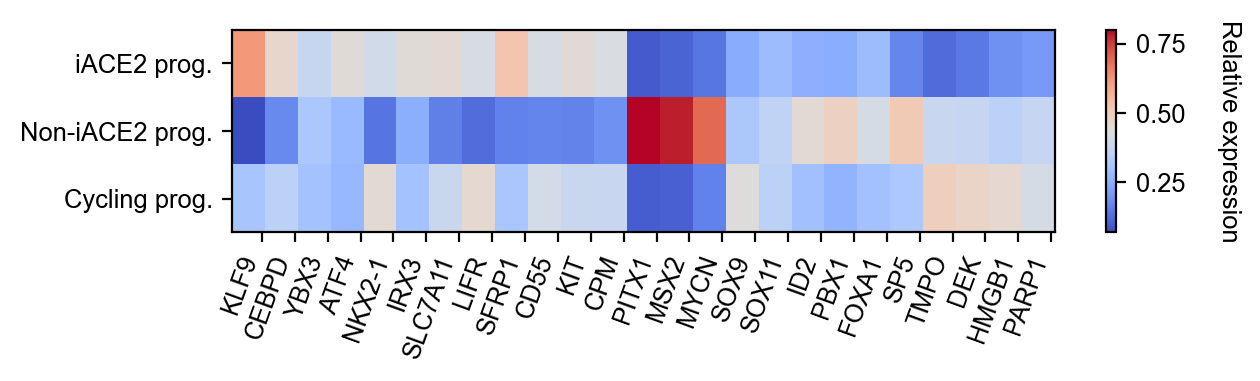

In [21]:
cs.settings.set_figure_params(fontsize=10)
state_info=np.array(adata.obs['state_info'])

gene_list=['KLF9','CEBPD', 'YBX3', 'ATF4', 'NKX2-1','IRX3','SLC7A11', 'LIFR', #'HSPA5',
    'SFRP1',  'CD55', 'KIT', 'CPM', #'LDLR', 'GFRA1',
     'PITX1', 'MSX2', 'MYCN','SOX9', 'SOX11', 'ID2', 'PBX1', 'FOXA1',  'SP5', 'TMPO',
    'DEK', 'HMGB1', 'PARP1']#, 'TFDP1', 'HNRNPD', 'MYBL2']

selected_fates=['iACE2 prog.','Non-iACE2 prog.','Cycling prog.']
renames=['iACE2 prog.','Non-iACE2 prog.','Cycling prog.']
# selected_fates=['iACE2',['PENC', 'Gut', 'NLE', 'Endoderm']]
# renames=['iACE2','Non-iACE2']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata,selected_genes=gene_list,
            selected_fates=selected_fates,rename_fates=renames,horizontal=True,fig_width=6.5,fig_height=2)
